### GW tutorial 3: Generation of data and matched filtering

Author: Melissa Lopez

Email: m.lopez@uu.nl

In [185]:
%matplotlib inline
from pycbc.catalog import Merger
import pycbc.psd, pycbc.noise
import pylab
import matplotlib.pyplot as plt
import numpy as np
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector
import random
import lal as _lal

Previously, we have plotted the PSD of different detectors. Some PSDs are from previous runs (O3), while some others are the design sensitivity of future detectors.

The PSD characterizes the noise of the detector, so we can generate detector noise accordingly.

**Exercise 1:** Load the `aligo_O4high.txt` PSD to [generate](https://pycbc.org/pycbc/latest/html/pycbc.noise.html#pycbc.noise.gaussian.noise_from_psd) some Gaussian data.

_Hint:_ Minimum frequency is 10 Hz, sampling rate 4096 Hz and we want 20s of duration

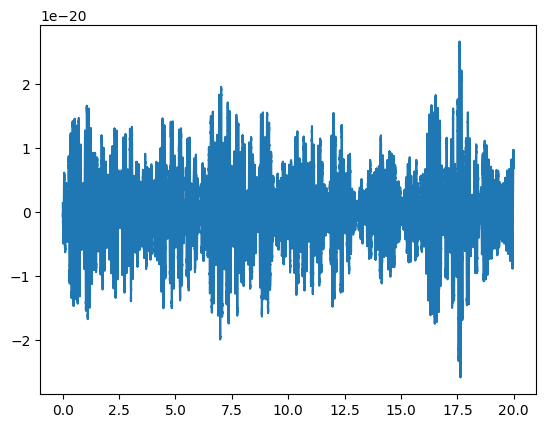

In [186]:
from pycbc.psd import read

# inputs
low_freq_cutoff = 10.21659 #Frequencies below this value (in hertz) are set to zero.
sampling_rate= 4096
duration = 20
length = duration * sampling_rate # samples= sampling rate * duration
delta_f = 1/duration # duration is 1/duration
delta_t = 1/sampling_rate # time resolution is 1/sampling rate

# use read function to read txt
psd_04high = read.from_txt("/content/aligo_O4high.txt", length, delta_f, low_freq_cutoff, is_asd_file=True)

# generate gaussian noise
gaussian_noise = pycbc.noise.gaussian.noise_from_psd(length, delta_t, psd_04high, seed=None)

# plot
plt.plot(gaussian_noise.sample_times, gaussian_noise)

As you can see. the generated noise is "coloured" according to the detector noise. Now, we would like to add a simulated gravitational wave signal in our detector noise.

**Exercise 2:** Using [this function](https://pycbc.org/pycbc/latest/html/pycbc.waveform.html#pycbc.waveform.waveform.get_td_waveform) to generate waveforms in time domain, provide the plus and cross polarization of a binary black hole merger of $m_{1} = m_{2} = 50$ at 2000 Mpc. Use the waveform approximant "IMRPhenomD". How does the waveform amplitude compare to the detector noise?

The waveform comes from the source, but it needs to be projected in the detector. [Project](https://pycbc.org/pycbc/latest/html/pycbc.detector.html#pycbc.detector.ground.Detector.project_wave) the waveform on LIGO Livingston (L1) at random sky-location and polarization. You can specify your detector with [this](https://pycbc.org/pycbc/latest/html/pycbc.detector.html#pycbc.detector.ground.Detector) function. How does the waveform change because of this projection?

_Hint:_ Right ascension range is $[0, 2\pi]$, declination is $[-2\pi, 2\pi]$ and polarization is $[0, 2\pi]$.

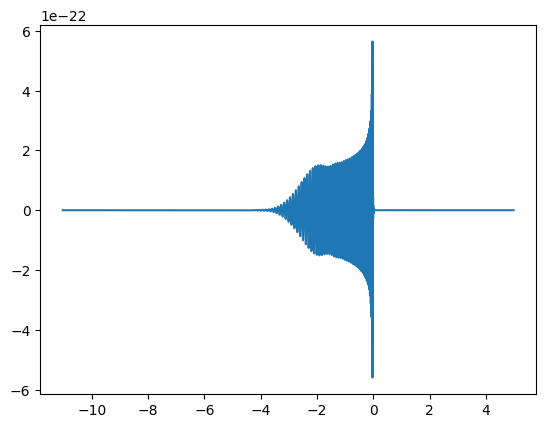

In [187]:
# inputs
# mass1 : {None, float} The mass of the first component object in the binary (in solar masses).
# mass2 ({None, float}) – The mass of the second component object in the binary (in solar masses).
# distance = Luminosity distance to the binary (in Mpc).
# approximant ({None, str}) – A string that indicates the chosen approximant.

# outputs
# hplus (TimeSeries) – The plus polarization of the waveform.
# hcross (TimeSeries) – The cross polarization of the waveform.

# plus and cross polarization
hplus , hcross = pycbc.waveform.waveform.get_td_waveform(template=None, mass1 = 50, mass2 = 50, distance = 2000, approximant = "IMRPhenomD", f_lower = low_freq_cutoff, delta_t = delta_t)

# project the waveform

from pycbc.detector import Detector

#inputs
# hp (pycbc.types.TimeSeries) – Plus polarization of the GW
# hc (pycbc.types.TimeSeries) – Cross polarization of the GW
# ra (float) – Right ascension of source location
# dec (float) – Declination of source location
# polarization (float) – Polarization angle of the source
# method ({'lal', 'constant', 'vary_polarization'}) – The method to use for projecting the polarizations into the detector frame. Default is ‘lal’.
# reference_time (float, Optional) – The time to use as, a reference for some methods of projection. Used by ‘constant’ and ‘vary_polarization’ methods. Uses average time if not provided.

# these only accept floats, and ranges are too big so we choose a random number in the range
ra_random = np.random.uniform(0, 2*np.pi)
dec_random = np.random.uniform(-np.pi/2, np.pi/2)
polarization_random = np.random.uniform(0, 2*np.pi)

# specifiy detector and project wave
wave_projection = Detector("L1").project_wave(hp = hplus, hc = hcross, ra = ra_random, dec = dec_random, polarization = polarization_random , method='lal', reference_time=None)

#plot
plt.plot(wave_projection.sample_times, wave_projection)

**Exercise 2:** From before our detector noise is 20s long. Add the GW into noise after 5s. We also need to get the first 4s to estimate the PSD in the next excercise. Make an overlaid plot with the total data, the portion of data where the GW is added and the data needed to estimate the PSD.

_Bonus:_ Can you also plot the GW signal?


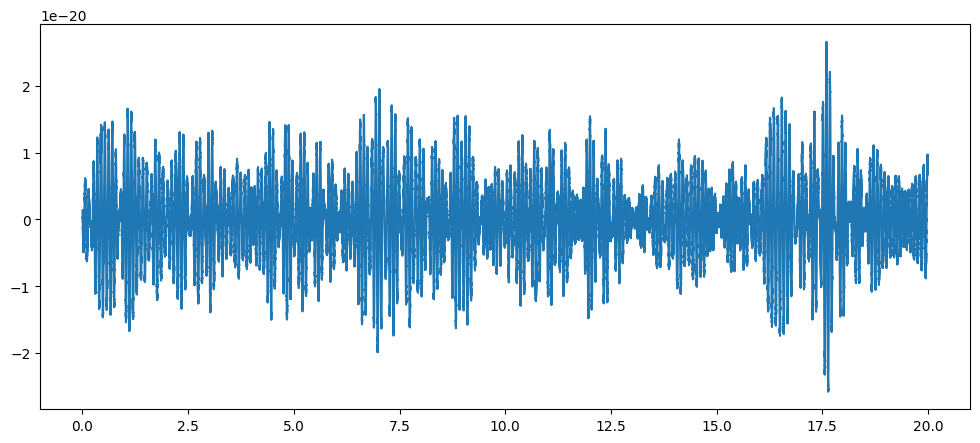

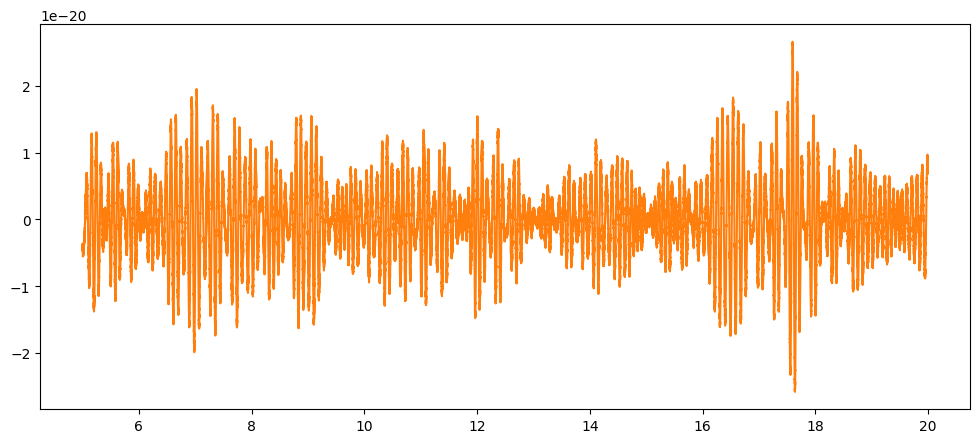

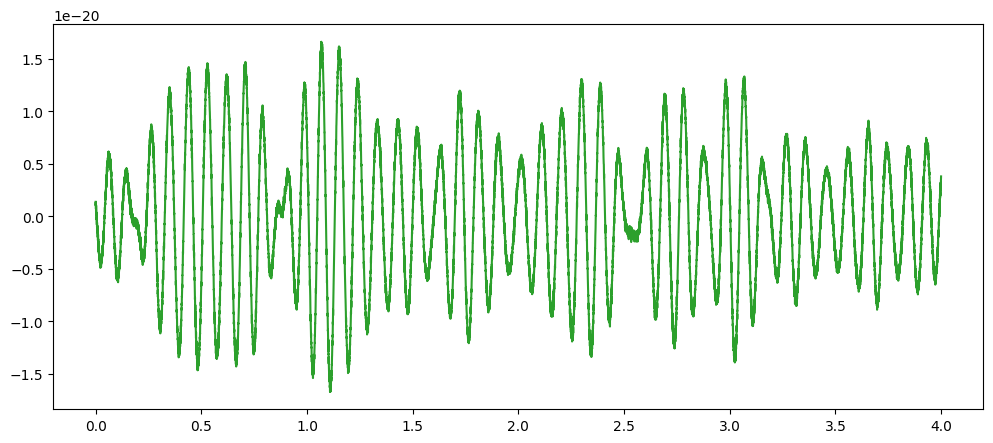

In [188]:
plt.figure(figsize=(12,5))
plt.plot(gaussian_noise.sample_times, gaussian_noise, label='noise + GW', color='C0')
plt.show()

# GW
plt.figure(figsize=(12,5))
start_idx = int(5 * sampling_rate) # add the GW noise after 5 s
end_idx = start_idx + len(wave_projection) # length of the GW
plt.plot(gaussian_noise.sample_times[start_idx:end_idx], gaussian_noise[start_idx:end_idx], label='GW', color='C1')
plt.show()

# PSD estimation (first 4s)
plt.figure(figsize=(12,5))
plt.plot(gaussian_noise.sample_times[:int(4*sampling_rate)], gaussian_noise[:int(4*sampling_rate)], label='data for PSD estimation', color='C2')
plt.show()

**Exercise 3:** In a proper search we do not really have the PSD handy. We want to estimate the PSD with Welch's method (see [here](https://ccrma.stanford.edu/~jos/sasp/Welch_s_Method.html) for details), but we want to use the 4s of the beginning where the GW is not present using [this function](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.estimate.welch). Plot the estimated PSD. Note that before we used a dummy whitening, and this one is a bit better.

What is the $\Delta_f$ of the estimated PSD? What is $\Delta_f$ of the data we want to whiten to see the GW signal?

_Hint:_ `seg_stride (int)` is usually half of `seg_len`.


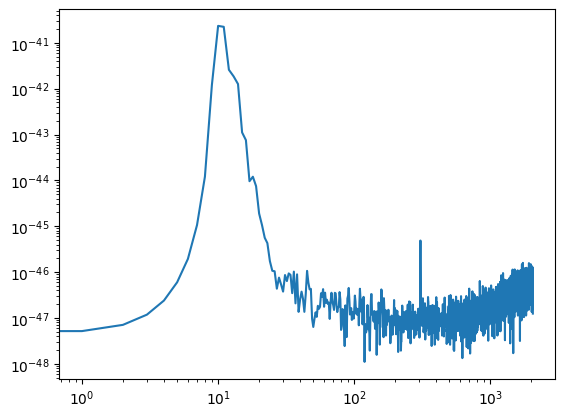

In [189]:
# estimate the PSD with Welch's method (time series to frequency series)
psd = pycbc.psd.estimate.welch(gaussian_noise[:int(4*sampling_rate)], seg_len=4096, seg_stride=2048, window='hann', avg_method='median', num_segments=None, require_exact_data_fit=False)

plt.loglog(psd.sample_frequencies, psd)

Now that we have the PSD we need to interpolate it to match our data and then limit the filter length of 1 / PSD. After this, we can directly use this PSD to filter the data. Since the data has been highpassed above 12 Hz, and will have low values below this we need to informat the function to not include frequencies below this frequency.

**Exercise 4:** Use the functions [interpolate](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.estimate.interpolate) and [inverse_spectrum_truncation](https://pycbc.org/pycbc/latest/html/pycbc.psd.html#pycbc.psd.estimate.inverse_spectrum_truncation) to achieve a proper formatting of the PSD.

_Hint:_ `max_filter_len (int)` is $4 \times$ sampling_rate. Note that the original PSD has a minimum frequency of 12Hz.

In [190]:
interpolated_series = pycbc.psd.estimate.interpolate(psd, gaussian_noise.delta_f, length=None)
inverse_spectrum_truncation_4psd = pycbc.psd.estimate.inverse_spectrum_truncation(interpolated_series, max_filter_len = 4 * sampling_rate, low_frequency_cutoff=12, trunc_method=None)

Now that the PSD is ready, we can whiten the data. Before we used a PyCBC function, but mathematically this is defined as

\begin{equation}
\tilde{d_w}(f) = \tilde{d}(f)/S_{n}^{-1/2}(f)
\end{equation}
where $\tilde{d}$ and $\tilde{d_w}(f)$ are the Fourier transform of the coloured data and whitened data, respectively.

**Exercise 5:** Whiten the data using the interpolated PSD. Crop 5s at the beginning and the end to avoid border effects (_aliasing_) and bandpass it as in the previous exercise. Can you see the GW signal?

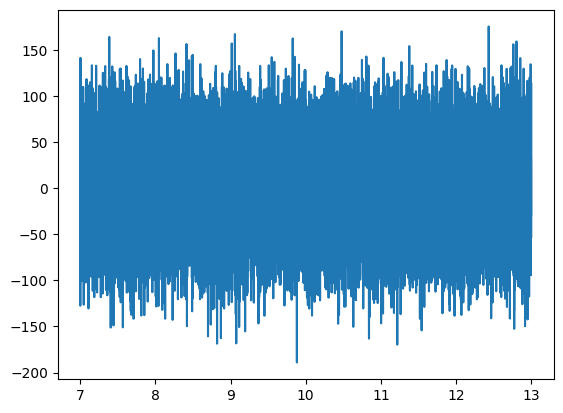

In [191]:
from pycbc.filter import highpass_fir, lowpass_fir

whitened_data = gaussian_noise.whiten(segment_duration = 4, max_filter_duration = 4, trunc_method='hann', remove_corrupted=True, low_frequency_cutoff=12, return_psd=False)

whitened_data = whitened_data.crop(5, 5) #crop 5s

# bandpass the data
data_highpass = highpass_fir(whitened_data, 30 , order=512)
data_bandpass = lowpass_fir(data_highpass, 250 , order=512)
plt.plot(whitened_data.sample_times, whitened_data, label='whitened data')


So far, we buried a GW signal  $h(t)$ in stationary and Gaussian noise $n(t)$ with zero mean, such that $s(t) = h(t) + n(t)$. Given the optimal filter  $K(t)$,

\begin{equation}
\label{eq:filteredsignal}
\hat{s} = \int_{-\infty}^{\infty}  K(t)s(t) dt = \int_{-\infty}^{\infty} \tilde{K}(f)^{*}\tilde{s}(f) df, \quad \text{ where }  \tilde{s}(f) = \int_{-\infty}^{\infty} s(t)e^{-2 \pi i ft}dt
\end{equation}
where $\hat{s}$ is the filtered value of $s(t)$, $^*$ represents the complex conjugate, and $\tilde{\cdot }\ $ the Fourier transform.

The detection statistic that is maximised by the optimal filter $K(t)$  will be the SNR, defined as $\rho = S/N$. $S$ is the expected value of $\hat{s}$ when $h(t) \neq 0$, while $N$ is the squared root of the noise variance when $h(t) =0$. It can be demonstrated that the optimal filter $K(t)$ is the model of the GW signal itself, known as _template_.

The fundamental modelled detection technique is called "matched filtering", since the filter function is chosen to "match" the signal we are looking for. We can write the SNR between an unknown time series $s(t)$ and the template $h_{m}$ as

\begin{equation}
\label{eq:wienerscalar}
\rho =  4 \text{Re} \int_{0}^{\infty} \frac{\tilde{s}^{*}(f)}{S_{n}(f)} \tilde{h_{m}}(f) df.
\end{equation}



**Exercise 6:** Use the [matched_filter](https://pycbc.org/pycbc/latest/html/pycbc.filter.html#pycbc.filter.matchedfilter.matched_filter) function to filter the coloured data with the template. Crop the SNR time series 5s at each side and plot it together with the whitened data. Where is the GW signal? Note that the y-axis of the whitened data is _amplitude_ and the y-axis of the SNR timeseries is _SNR_.

How much is the maximum of the absolute value of the SNR time series? If it is larger than 5 it will generate a "trigger" for further analysis. Will the trigger be generated?

Note that the parameter space of GW signals is vast, so to find these signals, we will need to create a template bank and do this process for thousands of templates. Then, this becomes a high-performance computing problem!

_Hint_: you need to [resize](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.array.Array.resize) the template and use [cyclic_time_shift](https://pycbc.org/pycbc/latest/html/pycbc.types.html#pycbc.types.frequencyseries.FrequencySeries.cyclic_time_shift)

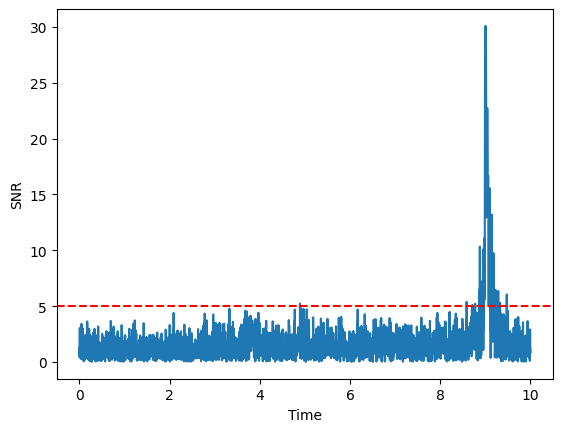

Maximum SNR: 30.096638718084048


In [192]:
wave_projection.resize(len(gaussian_noise)) # to make wave-projection and gaussian_noise ahve the same length or we get error

snr = pycbc.filter.matchedfilter.matched_filter(template = wave_projection, data = gaussian_noise, psd= inverse_spectrum_truncation_4psd, low_frequency_cutoff=12, high_frequency_cutoff=250, sigmasq=None)

snr = snr.crop(5, 5)

snr_abs = abs(snr)

snr_abs = snr_abs.cyclic_time_shift(snr_abs.start_time)

plt.plot(snr_abs.sample_times, snr_abs, label='SNR')
plt.axhline(5, color='r', linestyle='--', label='Trigger threshold')
plt.xlabel('Time')
plt.ylabel('SNR')
plt.show()

print("Maximum SNR:", snr_abs.max())

Good job arriving at the end of the tutorial! This was a small peak at GW data analysis that I hope you found interesting.

There is a bonus track exercise if you are bored, but we can also have a chat about some more GW data analysis if you prefer.